## Import Libraries

In [39]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

## Get the Data

In [6]:
housing=pd.read_csv('../data/housing.csv')
housing.info()
display(housing.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Cleaning the Data

In [7]:
#First let's check the null values
housing_copy=housing.copy()
housing_copy.isnull().sum().sort_values(ascending=False)

total_bedrooms        207
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

**total_bedrooms** contains null values wich I choose to handle it using knnimputer

In [9]:
knn_imputer = KNNImputer(n_neighbors=5)
housing_copy['total_bedrooms']=knn_imputer.fit_transform(housing_copy[['total_bedrooms']])

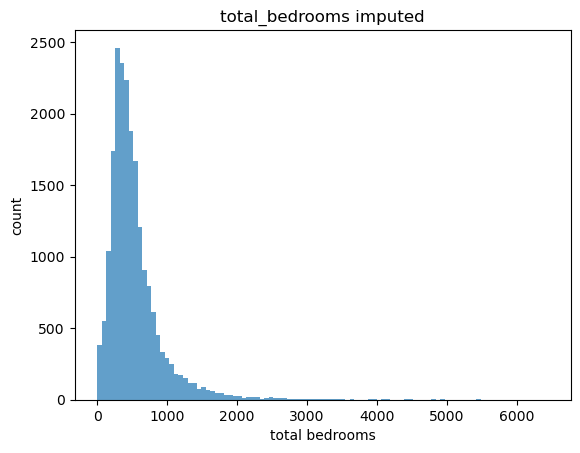

In [10]:
plt.hist(housing_copy['total_bedrooms'],bins=100,alpha=0.7)
plt.title('total_bedrooms imputed')
plt.xlabel('total bedrooms')
plt.ylabel('count')
plt.show()

In [12]:
#Checking the duplicated values
print(f'Number of Duplicated rows: {housing_copy.duplicated().sum()}')

Number of Duplicated rows: 0


## Categorical Analysis

In [13]:
#Let's seperate the categorical features from others

cat_features=[feature for feature in housing_copy.columns if housing_copy[feature].dtypes==object]
cat_features

['ocean_proximity']

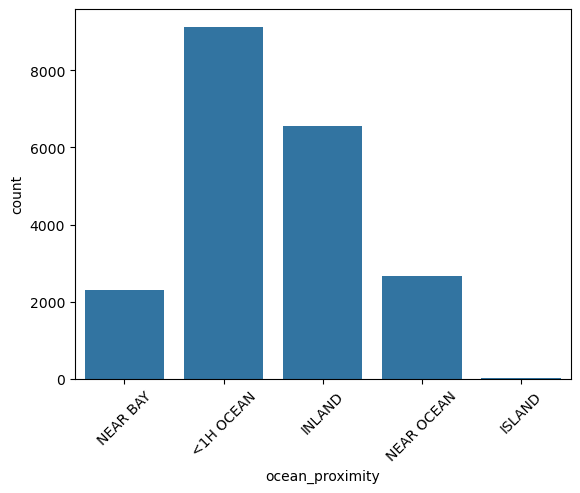

In [14]:
sns.countplot(data=housing_copy, x="ocean_proximity")
plt.xticks(rotation=45)
plt.show()

The moset frequent **ocean_proximity** is <1H OCEAN and it means most of the district are in that distance with the ocean

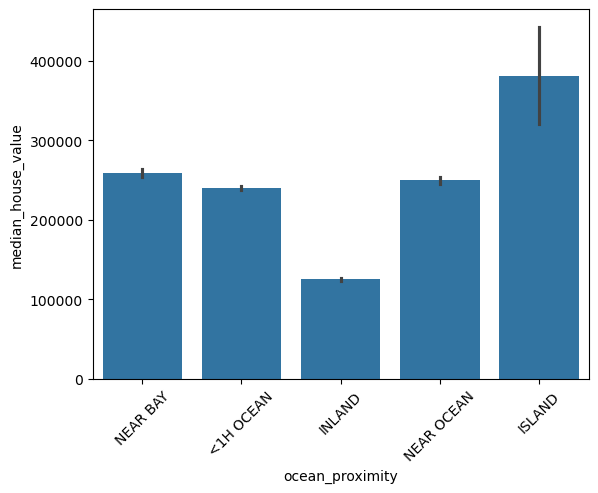

In [15]:
sns.barplot(data=housing_copy, x="ocean_proximity", y="median_house_value")
plt.xticks(rotation=45)
plt.show()

Districts in the **ISLAND** has higher median house value comparing to others.

## Numerical Analysis

In [16]:
#First we go for discrete values
discrite_featuers=['total_bedrooms','total_rooms','households','housing_median_age']

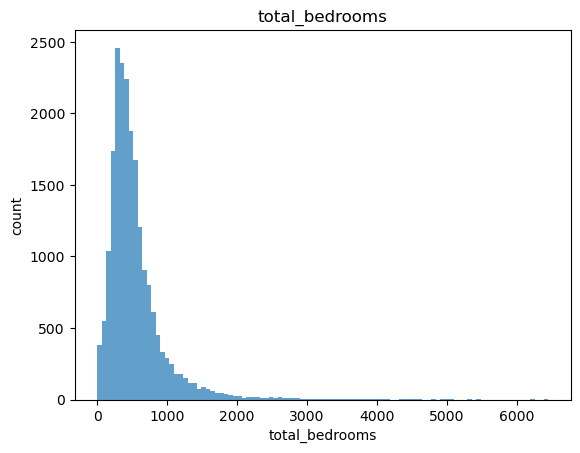

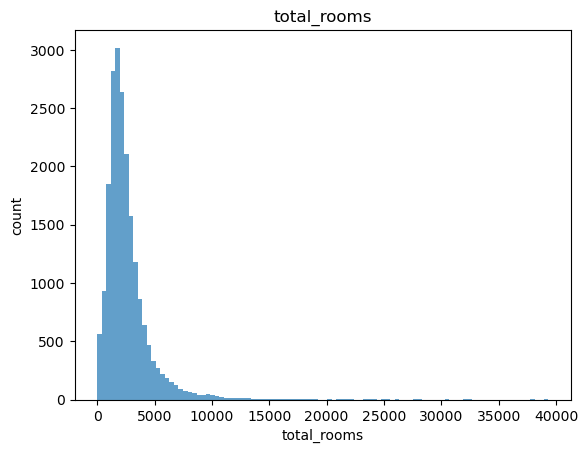

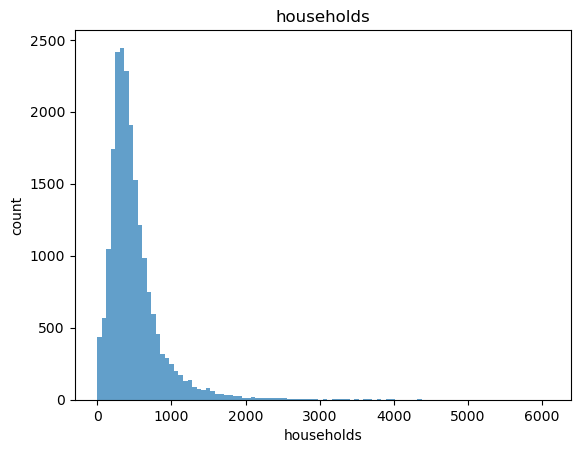

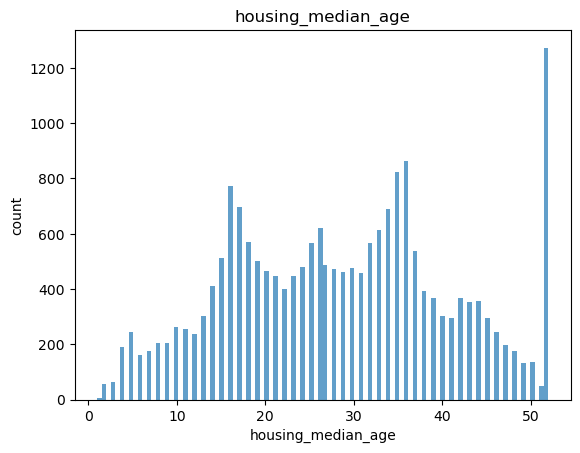

In [17]:
for i in discrite_featuers:
    plt.figure()
    plt.hist(housing_copy[i], bins=100,alpha=0.7)
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('count')
    plt.show()

In [18]:
#Let's check the skewness of the data
for i in discrite_featuers:
    print(f'{i} skewness: {np.round(housing_copy[i].skew(),4)}')

total_bedrooms skewness: 3.477
total_rooms skewness: 4.1473
households skewness: 3.4104
housing_median_age skewness: 0.0603


- The first problem I see is that the **housing_median_age** is caped at the end.Probabely houses older than that where caped at the end and it's not good

- Other columns are clearlly skewed to the right

In [19]:
#Let's check the number of outliers in each feature
#function to detect outlayers
def outlayer_detection(x):
    outlayers=[]
    q1=np.quantile(x,0.25)
    q3=np.quantile(x,0.75)
    iqr=q3-q1
    
    lower_bound=q1-1.5*iqr
    upper_bound=q3+1.5*iqr
    for i in x:
        if i<lower_bound or i>upper_bound:
            outlayers.append(i)
    return outlayers

In [20]:
#check the number of outliers before implementing log1p
print('Befor implementing log1p:')
for i in discrite_featuers:
    print(f' {i}: {len(outlayer_detection(housing_copy[i]))}')

Befor implementing log1p:
 total_bedrooms: 1306
 total_rooms: 1287
 households: 1220
 housing_median_age: 0


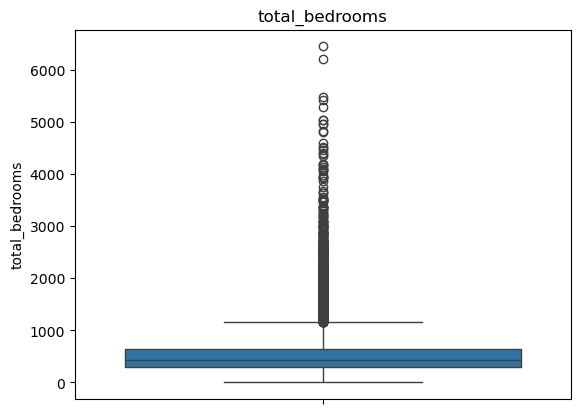

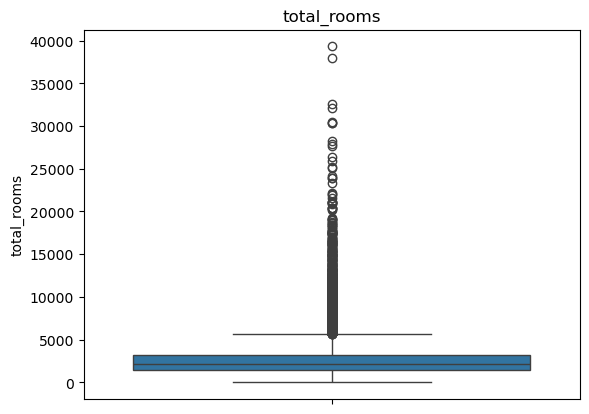

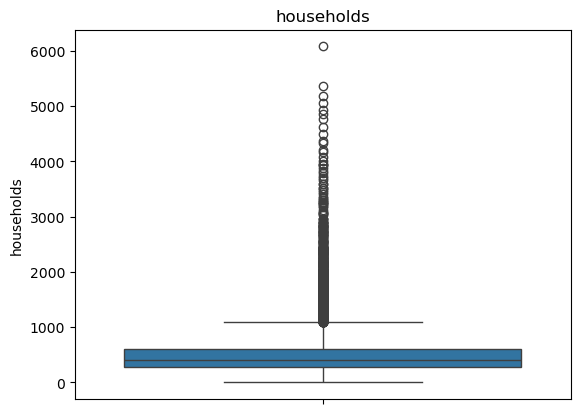

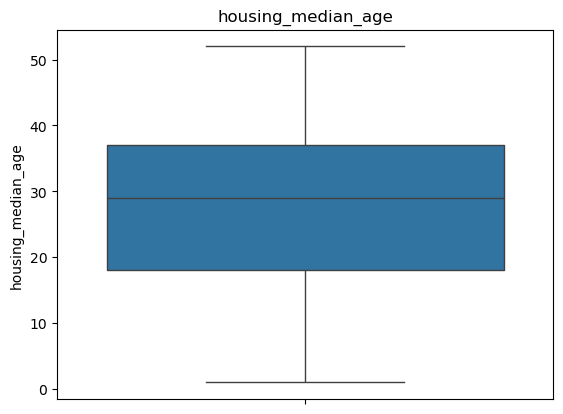

In [21]:
#Visualizing outliers using boxplot
for i in discrite_featuers:
    plt.figure()
    sns.boxplot(housing_copy[i])
    plt.title(i)
    plt.show()

Data has significant number of outliers so I try to limit them using log1p

In [22]:
#Since most of features are skewed to the write i think using log could be a good choice
discrite_featuers_new=discrite_featuers[:-1]
housing_copy[discrite_featuers_new]=np.log1p(housing_copy[discrite_featuers_new])

#For median_house_age wich is not skewed standardscaller is better
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
housing_copy['housing_median_age']=scaler.fit_transform(housing_copy[['housing_median_age']])

In [23]:
#Let's check the skewness after implementing log1p
for i in discrite_featuers:
    print(f'{i} skewness:{housing_copy[i].skew()}')

total_bedrooms skewness:-1.005686238536701
total_rooms skewness:-1.0755326843333637
households skewness:-1.0516074281263579
housing_median_age skewness:0.060330637599136865


The data is still moderatlly skewed but it's better

In [24]:
print('After implementing log1p:')
for i in discrite_featuers:
    print(f' {i}: {len(outlayer_detection(housing_copy[i]))}')
     

After implementing log1p:
 total_bedrooms: 836
 total_rooms: 957
 households: 882
 housing_median_age: 0


- **toal_bedrooms** outliers droped obout: 470
- **total_rooms** outliers droped obout: 330
- **households** outliers droped about: 338

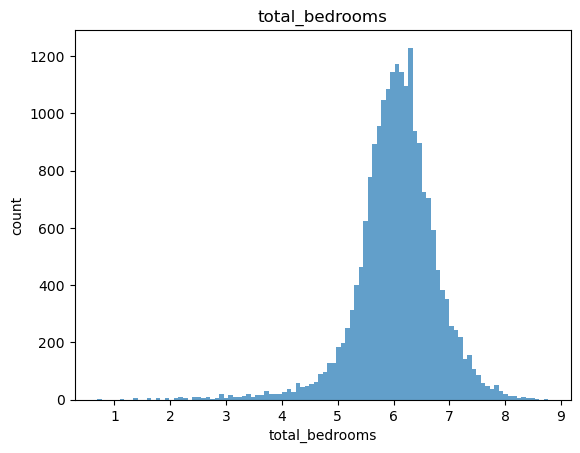

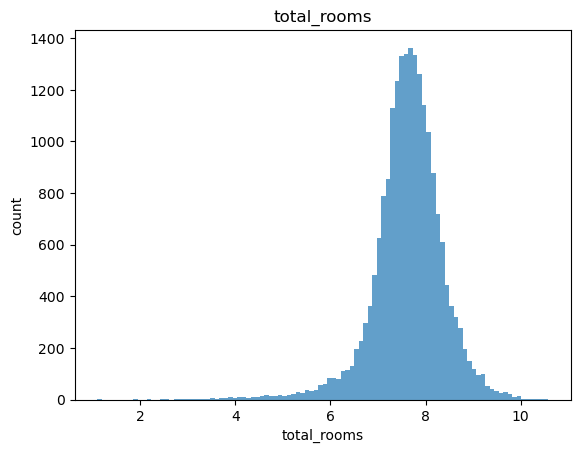

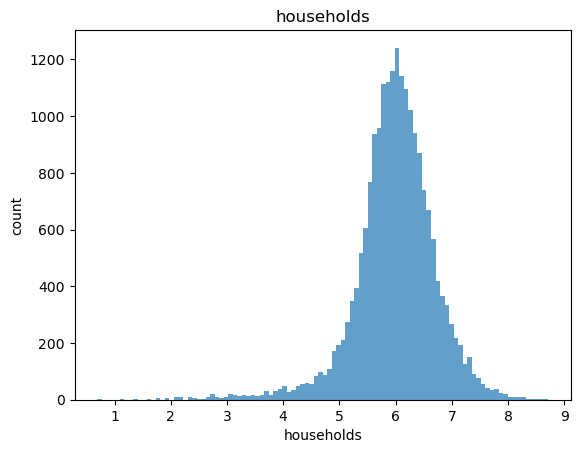

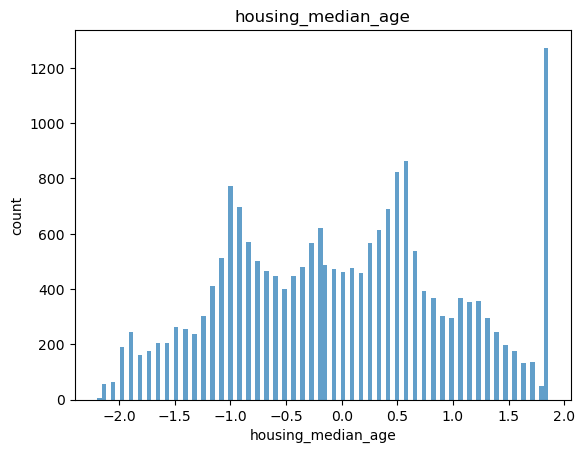

In [25]:
#Let's see the data after implementing log1p
for i in discrite_featuers:
    plt.figure()
    plt.hist(housing_copy[i], bins=100,alpha=0.7)
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('count')
    plt.show()

## Continuous Features

In [26]:
#Continuous features
continuous_features=['longitude','latitude','median_income','median_house_value']

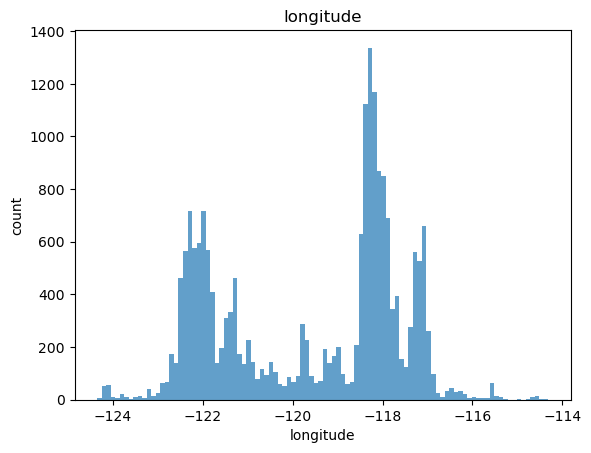

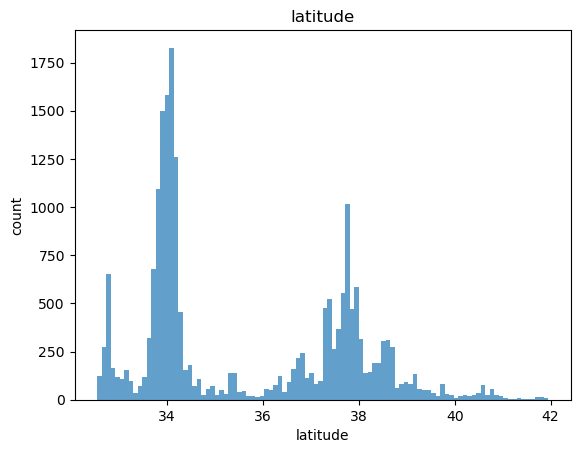

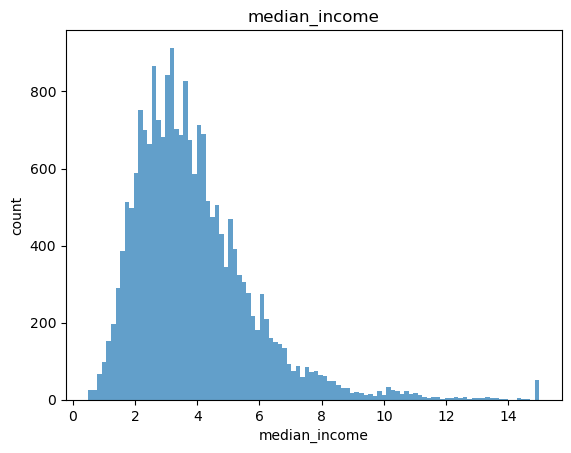

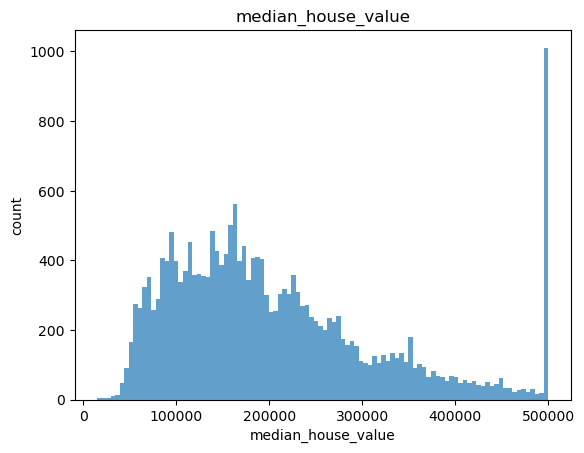

In [27]:
for i in continuous_features:
    plt.figure()
    plt.hist(housing[i],bins=100,alpha=0.7)
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('count')
    plt.show()

In [28]:
#Let's check the skewness of the data
for i in continuous_features:
    print(f' {i}: {len(outlayer_detection(housing_copy[i]))}')
     

 longitude: 0
 latitude: 0
 median_income: 681
 median_house_value: 1071


- both **longitude** and **latitude** has irregulare shape wich needs to be handled

- **median_income** is skewed to the right

- **median_house_value** wich the the target variable is caped at the 500000 and it's a problem and it is skewed too.

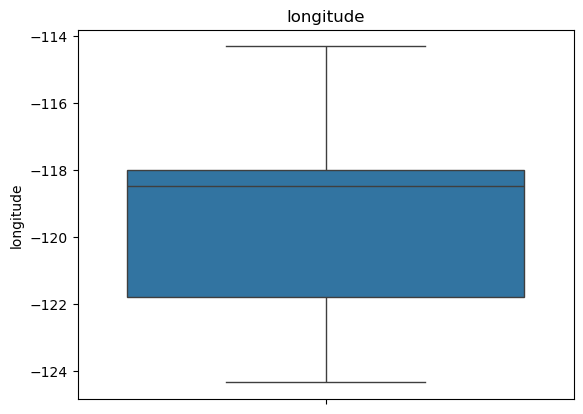

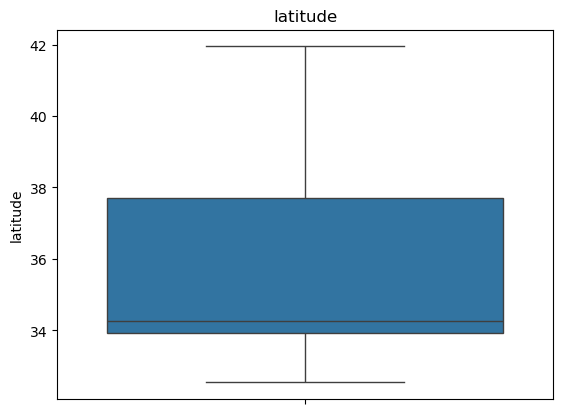

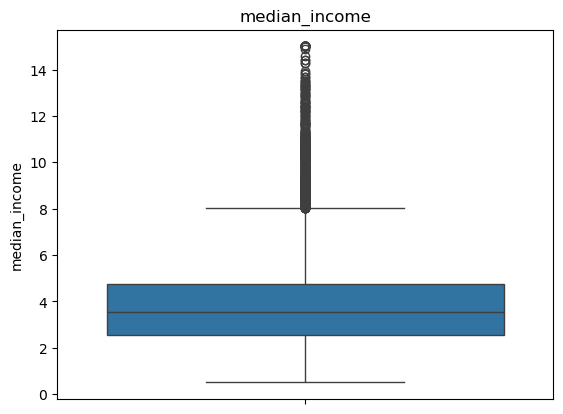

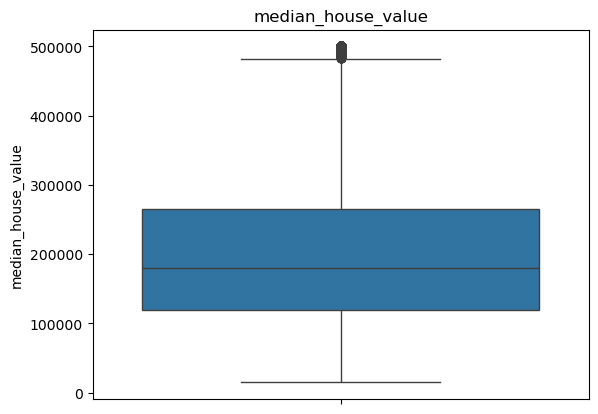

In [29]:
#let's check the outliers visualy
for i in continuous_features:
    plt.figure()
    sns.boxplot(housing[i])
    plt.title(i)
    plt.show()

In [30]:
for i in continuous_features:
    print(f'{i} skewness: {housing[i].skew()}')

longitude skewness: -0.2978012079524362
latitude skewness: 0.46595300370997006
median_income skewness: 1.6466567021344465
median_house_value skewness: 0.9777632739098341


- The **median_income** has a noticable outliers.

- **median_house_value** has outliers too.

In [31]:
#Longitude and Latitude just need to be scaled
from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()
housing_copy[['longitude','latitude']]=min_max.fit_transform(housing_copy[['longitude','latitude']])

#Median_income and median_house_value are skewed to the right so we can use log1p
housing_copy['median_income']=np.log1p(housing_copy['median_income'])

#We live median_house_value as the label alone for know
#But we know wich it isn hase been scaled before because of the range of values and thy don't look like house prices in dolors

In [32]:
print('After implementing log1p:')
for i in continuous_features:
    print(f' {i}: {len(outlayer_detection(housing_copy[i]))}')
     

After implementing log1p:
 longitude: 0
 latitude: 0
 median_income: 226
 median_house_value: 1071


- **median_income** outliers droped about: 455

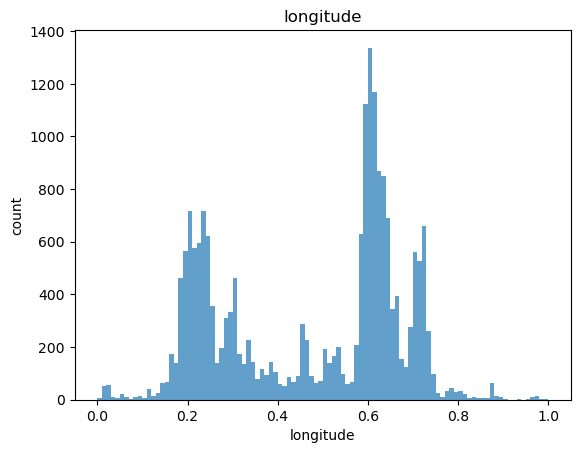

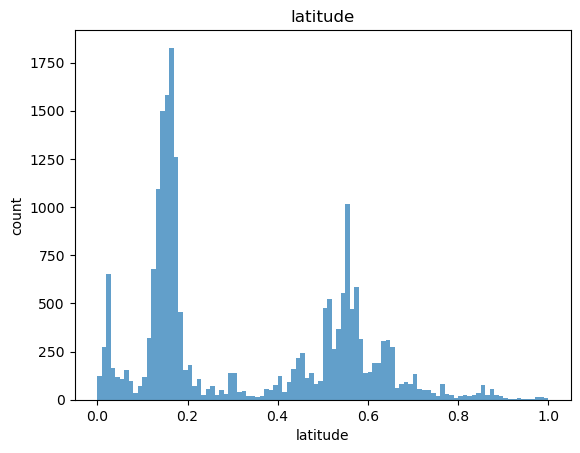

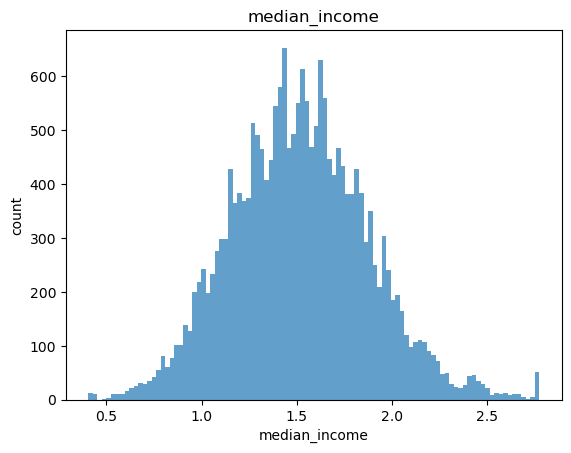

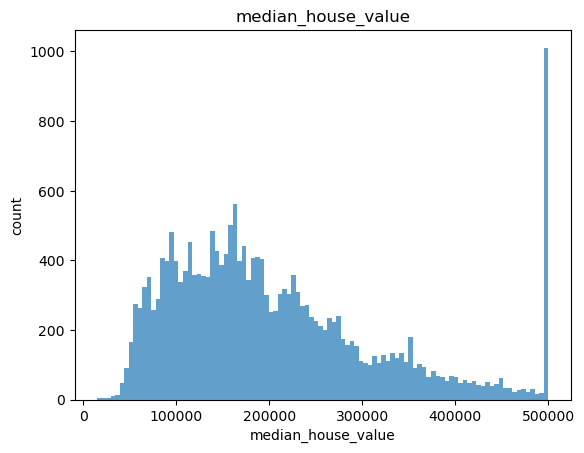

In [33]:
#let's watch the continuous data after scalling

for i in continuous_features:
    plt.figure()
    plt.hist(housing_copy[i],bins=100,alpha=0.7)
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('count')
    plt.show()

In [34]:
for i in continuous_features:
    print(f'{i} skewness: {housing_copy[i].skew()}')

longitude skewness: -0.29780120795240994
latitude skewness: 0.4659530037099733
median_income skewness: 0.22608313067130548
median_house_value skewness: 0.9777632739098341


- Since we implemented the log1p just for **median_income** other columns remain unchanged, but the **median_income** skewness decreased a lot.

## Conclusion

- Despite all the scalling and transformatoing the data still has outliers and skewness in it and needs to be tweked more

- Binning and creating simillarity features for some columns like **housing_median_age** and **longitued,lattitued** can be helpfull.

- Sadly at some columns like **median_house_value** and others we saw the data being caped at some point wich is not good and we can't fix it because it needs domain knowledge and data

## Feature Engineering

In [35]:
#I found below combinations helpfull
housing_copy['bedrooms_ratio']=housing_copy['total_bedrooms']/housing_copy['total_rooms']
housing_copy['rooms_per_house']=housing_copy['total_rooms']/housing_copy['households']
housing_copy['income_population_ratio']=housing_copy['median_income']/housing_copy['population']

## Feature Selection and Feature Importance

correlations

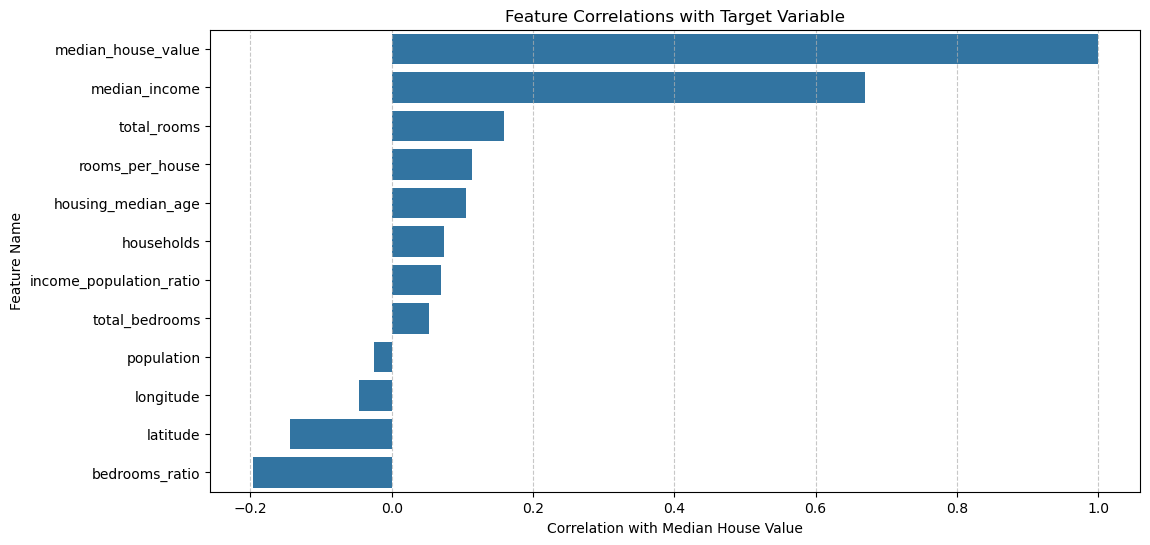

In [37]:
#computing the correlations between features and the label
housing_corr = housing_copy.corr(numeric_only=True)['median_house_value'].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(y=housing_corr.index, x=housing_corr.values)

plt.xlabel('Correlation with Median House Value')
plt.ylabel('Feature Name')
plt.title('Feature Correlations with Target Variable')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


Anova-test

In [40]:
#Calculating numerical features importance using Anova-test
numerical_features=discrite_featuers+continuous_features+['bedrooms_ratio','rooms_per_house','income_population_ratio']

X = housing_copy[numerical_features].drop(columns='median_house_value')
y = housing_copy['median_house_value']  

anova_selector = SelectKBest(score_func=f_regression, k='all')  
X_selected = anova_selector.fit_transform(X, y)

scores = anova_selector.scores_
feature_scores = pd.DataFrame({'Feature': X.columns, 'ANOVA Score': scores})
print(feature_scores.sort_values(by='ANOVA Score', ascending=False))

                   Feature   ANOVA Score
6            median_income  16802.949938
7           bedrooms_ratio    831.597767
1              total_rooms    538.199930
5                 latitude    438.005453
8          rooms_per_house    271.718228
3       housing_median_age    232.841479
2               households    112.441167
9  income_population_ratio    103.049281
0           total_bedrooms     58.157072
4                longitude     43.698976


Using Random Forest to detect feature's importance:

In [41]:
#Computing numerical feature's importance using randomforest
X = housing_copy[numerical_features].drop(columns='median_house_value')
y = housing_copy['median_house_value']  

rnd_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rnd_reg.fit(X, y)

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rnd_reg.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

perm_importance = permutation_importance(rnd_reg, X, y, scoring='neg_mean_absolute_error')

perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

perm_importance_df


,Feature,Importance
6,median_income,65416.162995
5,latitude,58328.052656
4,longitude,57126.614705
3,housing_median_age,17239.987685
7,bedrooms_ratio,13462.783733
9,income_population_ratio,12393.766549
8,rooms_per_house,8750.450145
1,total_rooms,6529.858089
0,total_bedrooms,3923.290471
2,households,3589.240047


## Feature engineering and Tests conclusion:

- Some Combinations of features where added to the dataset

- Accourding to the tests It is better to ignore **households**

- Note that we have used **households** in the combinations we created wich had better test scores, and with regard to  it's low test score it's better to ignore it.